<a href="https://colab.research.google.com/github/conster303/PFA_ML_Sandbox_CMS/blob/main/PFA_PCAk_NMFk_Sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Clustering Sandbox

##Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Set up directory where data is stored in your google drive

%cd '/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES'

Mounted at /content/drive
/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist

from sklearn.decomposition import NMF 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import normalize

import random

#If we want to reproduce results/deterministic solutions, pass an integer for random_state

RS = 42 # https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy
#RS = None


In [3]:
#To use hdf, pickle, etc., upgrade colab tables
!pip install --upgrade tables -q

##prepare training data

In [4]:
#Import PFA master hdf file preprocessing
import PFA_preprocessing_february2021 as pfa

df_features = pd.read_hdf('./PFA_dataframe_grid_march2021_df.h5', 'df_features')

#Invert fault recency - now young is high

df_features['FaultRecency'] = df_features['FaultRecency']*-1

extraFeatures = ['GravityDensity', 'MagneticDensity', 
                 'GeochemistryTemperature2',
                 'Silica_Distance', 'TufaOrTravertine_Distance',
                 'DEM-30m', 'FavorableStructuralSettings_Distance']

In [5]:
"""Call pfa preprocessing, N for numerical and C for categorical.

N is 0-1.2 scoring for 'Local-StructuralSetting', and C is 19 different structures 1hot encoded (~7 major and 12 hybrid).

The data is reduced (z-score) and scaled (standard). 

Distance from faults = distance_edt, also have option to change to gaussian filter 'gaussianFilter' """

"Call pfa preprocessing, N for numerical and C for categorical.\n\nN is 0-1.2 scoring for 'Local-StructuralSetting', and C is 19 different structures 1hot encoded (~7 major and 12 hybrid).\n\nThe data is reduced (z-score) and scaled (standard). \n\nDistance from faults = distance_edt, also have option to change to gaussian filter 'gaussianFilter' "

In [6]:
transformDict = {'features': ['Local-StructuralSetting',
                              'Local-QuaternaryFaultRecency',
                              'Local-QuaternaryFaultSlipDilation', 
                              'Local-QuaternaryFaultSlipRate',
                              'QuaternaryFaultTraces'], 
                 'transforms': ['gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'distance_edt'], 
                 'params': [10, 10, 10, 10, 20]}

# transformDict = {'features': ['QuaternaryFaultTraces'], 
#                  'transforms': ['distance_edt'], 
#                  'params': [20]}

dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_AllNumerical(df_features,
                                                                          transformFeatures=transformDict,
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=True, withMean=True)


In [7]:
Xall = dfn.copy()
columns = Xall.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [8]:
featureSets = [

# MASTER SET 1
################################
# featureSet = 0
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 1alt: master set 1 with new gravity/magnetic features substituted
################################
# featureSet = 1
################################
['QuaternaryFaultTraces',
 'GravityDensity',
 'MagneticDensity',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2: master set 1 + all local
################################
# featureSet = 2
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 3: master set 1 + geochemistry direct evidence 
################################
# featureSet = 3
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 4: union of master sets 2 and 3
################################
# featureSet = 4
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 2a: master set 1 + local structural setting
################################
# featureSet = 5
################################
['Local-StructuralSetting',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2b: master set 1 + favorable structural settings
################################
# featureSet = 6
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 4b: union of master sets 2b and 3
################################
# featureSet = 7
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 1m: master set 1 minus geodetic strain rate
################################
# featureSet = 8
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
# 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
# MASTER SET 1n: master set 1 minus dem-30m
################################
# featureSet = 9
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
# 'DEM-30m',
],

[
  'GeodeticStrainRate',
 'Earthquakes'
]


]

len(featureSets)

11

In [9]:
feature_set = 2

columns = featureSets[feature_set]

#update the feature set number so it is 1-9 for presentation
feature_set = feature_set+1

columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

In [10]:
dfInfo['T37'] = df_features['T37']
dfInfo['Domain'] = df_features['Domain']

dfInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


In [11]:
#Create a dataframe with all the normalized data

Info = pd.concat([dfn,dfInfo],axis=1,sort=False)
Info.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,...,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,-0.664854,...,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,-0.640521,...,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


## select benchmark sites based on trainCode distance

Select trainCode=1: for 83+ and 62- or trainCode=2: 415+ and 310-


In [12]:
X, y, XyInfo = pfa.makeBenchmarks(dfn, dfInfo, nullIndexes, 
                                          trainCode=1, randomize=True, balance=False)

Number of (+):  83   ; Number of (-):  62


In [13]:
# X, y, XyInfo = pfa.makeBenchmarks(dfC, dfInfoC, nullIndexesC, 
#                                   trainCode=1, randomize=True, balance=True)

In [14]:
print( X.shape, y.shape)

(145, 20) (145,)


In [15]:
X.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1599389,2.756795,2.015509,2.193071,1.878444,-1.064303,-1.177733,0.316930,-0.687134,2.521989,2.417621,-0.904863,-0.102774,2.165141,1.090220,-0.988426,11.355118,-1.135212,0.963373,-0.823267,-1.447438
1104608,-0.530227,-0.581814,-0.398818,-0.580812,-0.667953,-0.015821,-0.703223,0.910499,-0.620147,1.565355,-1.322751,0.250527,0.102914,0.051986,1.302250,-0.185826,-0.565421,-0.031340,-1.635721,0.311089
1578088,1.256178,1.571190,1.749735,1.457744,-0.965216,1.724801,0.852767,-0.031941,1.241855,2.049002,0.062224,-0.643047,0.666837,-1.332326,1.416784,10.883062,-1.007889,0.265265,-1.158565,-1.606663
35635,1.330940,2.361836,0.185405,2.206362,-1.064303,-0.845162,-0.589872,-0.276014,-0.920538,-1.178281,-0.632902,1.053704,-1.448916,1.090220,0.500513,6.734515,0.470638,-1.741306,-0.250680,-1.320758
267065,0.582876,1.000666,-0.220408,1.084497,-0.965216,2.488579,0.203579,-0.573084,-0.268238,-0.151136,-0.007385,0.069124,-1.086516,-1.447685,-1.102960,3.587468,-0.317923,-0.411498,0.685577,-1.477416


In [17]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
1599389,925.0,989.0,R926C990,533577.690182,4.489964e+06,notNull,12,1,1,1.0,57.945397,1.0,57.945397,19.0,32882.380251,299,0,12,3
1104608,639.0,416.0,R640C417,390327.690182,4.418464e+06,notNull,1,12,12,80.0,22190.635522,80.0,22190.635522,5.0,87.319086,0,0,12,3
1578088,913.0,424.0,R914C425,392327.690182,4.486964e+06,notNull,12,1,1,8.0,108.518720,8.0,108.518720,5.0,68449.447735,59,0,12,3
35635,20.0,1075.0,R21C1076,555077.690182,4.263714e+06,notNull,12,1,1,23.0,39.899642,23.0,39.899642,14.0,5882.121049,256,0,12,4
267065,154.0,953.0,R155C954,524577.690182,4.297214e+06,notNull,12,1,12,54.0,32890.552535,58.0,123.148899,14.0,48226.112862,242,0,1,4


In [18]:
#Create Dataframe with training site info
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
XyInfo.reset_index(drop=True, inplace=True)

Tsite= pd.concat([X,XyInfo],axis=1).reset_index(drop=True)
Tsite

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,...,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,2.756795,2.015509,2.193071,1.878444,-1.064303,-1.177733,0.316930,-0.687134,2.521989,2.417621,...,1.0,57.945397,1.0,57.945397,19.0,32882.380251,299,0,12,3
1,-0.530227,-0.581814,-0.398818,-0.580812,-0.667953,-0.015821,-0.703223,0.910499,-0.620147,1.565355,...,80.0,22190.635522,80.0,22190.635522,5.0,87.319086,0,0,12,3
2,1.256178,1.571190,1.749735,1.457744,-0.965216,1.724801,0.852767,-0.031941,1.241855,2.049002,...,8.0,108.518720,8.0,108.518720,5.0,68449.447735,59,0,12,3
3,1.330940,2.361836,0.185405,2.206362,-1.064303,-0.845162,-0.589872,-0.276014,-0.920538,-1.178281,...,23.0,39.899642,23.0,39.899642,14.0,5882.121049,256,0,12,4
4,0.582876,1.000666,-0.220408,1.084497,-0.965216,2.488579,0.203579,-0.573084,-0.268238,-0.151136,...,54.0,32890.552535,58.0,123.148899,14.0,48226.112862,242,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,-0.398323,-0.395663,-0.276137,-0.384507,0.095486,2.098599,-1.032969,-0.052316,0.787964,-0.168520,...,13.0,15535.628277,42.0,8721.569205,17.0,46.810451,0,0,12,4
141,0.907470,1.691896,0.051714,1.572034,-1.064303,0.592684,-0.971141,-0.311688,-0.804524,-0.962630,...,23.0,5903.705632,23.0,5903.705632,14.0,127.945950,256,0,12,4
142,0.479862,0.374872,-0.211106,0.325020,-0.073429,0.988957,0.028402,-0.393025,-1.124142,-0.981152,...,76.0,52204.747765,28.0,125.168399,27.0,5180.620343,0,0,1,4
143,1.252623,1.368831,2.363853,1.414393,-0.866128,4.804827,0.306625,0.782783,2.304218,0.745315,...,16.0,103.947344,16.0,103.947344,62.0,86405.465976,74,0,12,3


In [19]:
##############################
#Tsites
Tsite_Set = Tsite.copy()[columns]

Tsite_Set.rename(columns = {'QuaternaryFaultTraces':'QuaternaryFaultDistance'}, inplace = True)
Tsite_Pos = Tsite[Tsite['TrainCodePos']!=12]
Tsite_Neg = Tsite[Tsite['TrainCodePos']==12]
Tsite_PosLOW = Tsite_Pos[Tsite_Pos['TrainCodePosT130']==12] #lower  pos
Tsite_PosBM = Tsite_Pos[Tsite_Pos['TrainCodePosT130']!=12] #Benchmark  pos

Bring in data 

Select feature set

split into fairway &/or training sites

select function for 1 of the six methods pca, nmf, tsne (fairway, tsites)

#Build modules

function outputs - dataframes with W and H values from PC or NMF 

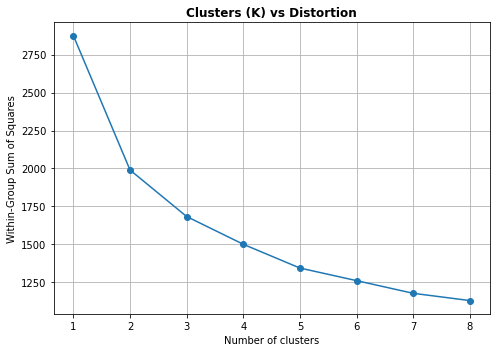

In [20]:
fig= plt.figure(figsize=(7,5)) 

#Append distortions to list
distortions = []
for i in range(1, 9): #test cluster values from 1-9
    km = KMeans(n_clusters=i, init='k-means++') 
    #Fit K-means to the first PCs which explain the most variance
    km.fit(Tsite_Set)
    distortions.append(km.inertia_)
K = range(1, 9)

plt.plot(K,distortions,marker='o')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Within-Group Sum of Squares')
plt.title('Clusters (K) vs Distortion',fontweight='bold')
plt.tight_layout ()    

In [21]:
#Set the number of clusters 

nCluster = 3



##PCA module


In [24]:
#Function that inputs the training set, number of clusters and outputs W and H 

#def PCA_tsite():

from sklearn.decomposition import PCA

n = len(Tsite_Set.columns)
pcamodel = PCA(n_components=n)


pcaTsites = pcamodel.fit_transform (Tsite_Set)

score = pcaTsites[:,0:2]

score[:,0].shape

xs = score[:,0]
ys = score[:,1]


#Produce a W 

pcaTsite_df = pd.DataFrame(pcaTsites,columns=[ "PC"+str(TSite_Set_Group) for TSite_Set_Group in range(1,pcamodel.n_components_+1)])


#Produce an H 

from sklearn.cluster import KMeans

nCluster = 3

Kmean = KMeans(n_clusters=nCluster,init = 'k-means++', verbose = 0, random_state=RS)

Kmean.fit(pcaTsite_df[['PC1','PC2','PC3','PC4']])


centers = np.copy(Kmean.cluster_centers_)

Labels = Kmean.labels_


df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([pcaTsite_df,Tsite, df_labels], axis=1, sort=False)

Centers = centers

C1_Center = Centers[0:1].T
C2_Center = Centers[1:2].T
C3_Center = Centers[2:3].T
C4_Center = Centers[3:4].T


#Somehow make this dynamic to the number of clusters - if else statement

#select cluster to multiply coefficients by 
Cluster1_results = pcamodel.components_[0:4 :]*C1_Center
Cluster2_results = pcamodel.components_[0:4 :]*C2_Center
Cluster3_results = pcamodel.components_[0:4 :]*C3_Center
#Cluster4_results = pcamodel.components_[0:4 :]*C4_Center

df_columns = ['PC1','PC2','PC3','PC4']

#set rows to be the feature columns
rows = list(Tsite_Set.columns)
C1_DF = pd.DataFrame(Cluster1_results.T,rows,df_columns)
C1_DF['Cluster1'] = (C1_DF['PC1'])+(C1_DF['PC2']+C1_DF['PC3']+C1_DF['PC4'])

C2_DF = pd.DataFrame(Cluster2_results.T,rows,df_columns)
C2_DF['Cluster2'] = (C2_DF['PC1'])+(C2_DF['PC2']+C2_DF['PC3']+C2_DF['PC4'])

C3_DF = pd.DataFrame(Cluster3_results.T,rows,df_columns)
C3_DF['Cluster3'] = (C3_DF['PC1'])+(C3_DF['PC2']+C3_DF['PC3']+C3_DF['PC4'])

C1_DF['Cluster2']=C2_DF['Cluster2']
C1_DF['Cluster3']=C3_DF['Cluster3']
C1_DF.columns
C1_DF_columns = ['Cluster1', 'Cluster2', 'Cluster3']
PC_Loading_4Sum = C1_DF.copy()[C1_DF_columns]

In [25]:
H = PC_Loading_4Sum

##NMF module

*   Convert data to be non-negative
*   Normalize data between 0 and 1
*   Determine k: Reconstruction error, silhoutte width, and variance explained.
*   To get reproducable results random_state and random_init are set to an integer. 

In [26]:
#Function that inputs the training set and outputs W and H 

#Function that inputs the training set, number of clusters and outputs W and H 

#def NMF_tsite():

from sklearn.decomposition import NMF 

#Make data non-negative. Add the min value of each variable to all row values.

Tsite_Set += np.abs(Tsite_Set.copy().min())

#Scale data from 0 to 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Tsite_SetScaled = scaler.fit_transform(Tsite_Set)

components = 4

nmfmodel = NMF(n_components= components, random_state=RS) #init is the method to initialize the procedure.


W = nmfmodel.fit_transform(Tsite_SetScaled)

H = nmfmodel.components_

H = normalize(H)
H = H.transpose()

Ws_Tsite = pd.DataFrame(W,columns= ["G"+str(Tsite_SetScaled) for Tsite_SetScaled in range(1,nmfmodel.n_components_+1)])
Ws_Tsite = pd.concat([Tsite_Set,Ws_Tsite], axis=1, sort=False)

from sklearn.cluster import MiniBatchKMeans

cols = Tsite_Set.columns


nCluster = 4

Kmean = MiniBatchKMeans(n_clusters=nCluster, init = 'k-means++',verbose=0,random_state= RS)

Kmean.fit(Ws_Tsite[['G1','G2','G3','G4']])

centers = np.copy(Kmean.cluster_centers_)

Labels = Kmean.labels_

df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([Ws_Tsite,Tsite, df_labels], axis=1, sort=False)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


#TsNE module

#Cluster analysis

In [27]:
#H, W, df_out = PCA_tsite(Tsite_Set)

#H, W, df_out = PCA_tsite(Tsite_Set)

#H, W, df_out = NMF_tsite(Tsite_Set)

#H, W, df_out = NMF_tsite(Tsite_Set)


<function matplotlib.pyplot.tight_layout>

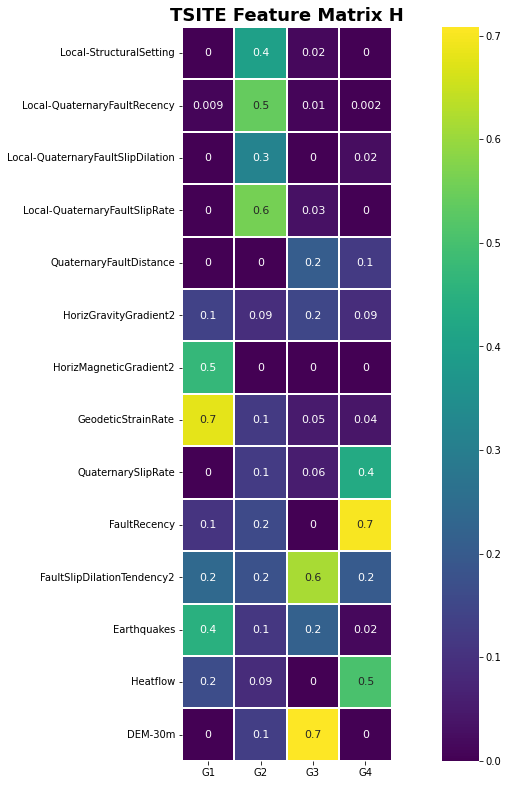

In [28]:



import seaborn as sns

#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))

ax = sns.heatmap(H,
                 cmap='viridis', linewidths=.95,
                xticklabels=[ "G"+str(Tsite_Set) for Tsite_Set in range(1,nCluster+1)],
                 yticklabels=list(Tsite_Set.columns), 
                 annot=True, annot_kws={"size": 11}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")
ax.set_title("TSITE Feature Matrix H",fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout

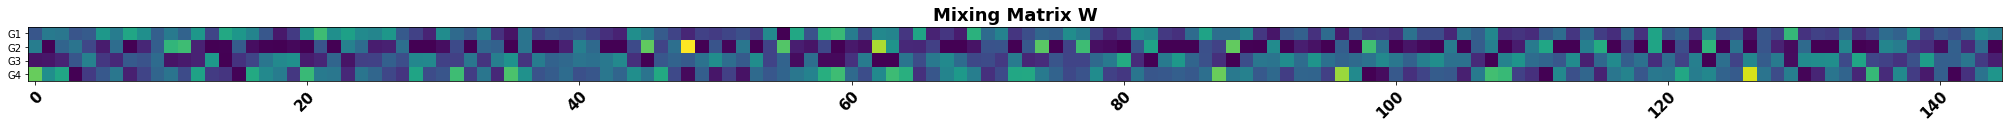

In [29]:
fig, ax = plt.subplots(figsize=(28,28.5))
im = ax.imshow(W.transpose(), cmap = 'viridis') # cmap='YlGnBu'

# We want to show all ticks...
ax.set_yticks(range(nmfmodel.n_components_))
ax.set_yticklabels( "G"+str(TSite_Set_Group) for TSite_Set_Group in range(1,nmfmodel.n_components_+1))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=15,fontweight='bold')


ax.set_title("Mixing Matrix W",fontsize=18,fontweight='bold');
fig.tight_layout()
plt.show()

make groups for training sites 



In [30]:
# #Join data into df_out data frame
# centers = np.copy(Kmean.cluster_centers_)

# Labels = Kmean.labels_

# df_labels = pd.DataFrame({'KMeansGrp':Labels,
#                           'Grp0_CntrX':centers[0,0],
#                           'Grp0_CntrY':centers[0,1],
#                           'Grp1_CntrX':centers[1,0],
#                           'Grp1_CntrY':centers[1,1]})

# df_out = pd.concat([pcaTsite_df,Tsite, df_labels], axis=1, sort=False)

# print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
# print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
# print('', file=sys.stdout, flush=True)

In [31]:

#Groups for the fairway
group1 = df_out[df_out['KMeansGrp']==0]
label1 = 'Cluster 1'
group2 = df_out[df_out['KMeansGrp']==1]
label2 = 'Cluster 2'
group3 = df_out[df_out['KMeansGrp']==2]
label3 = 'Cluster 3'
group4 = df_out[df_out['KMeansGrp']==3]
label4 = 'Cluster 4'

#Groups for positive sites
group5 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Positive T-Site - Cluster 1: ' + str(len(group5))
group6 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Positive T-Site - Cluster 2: ' + str(len(group6))
group7 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Positive T-Site - Cluster 3: ' + str(len(group7))
group8 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Positive T-Site - Cluster 4: ' + str(len(group8))

#Groups for negative sites 
group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label9 = 'Negative T-Site - Cluster 1: ' + str(len(group9))
group10 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label10 = 'Negative T-Site - Cluster 2: ' + str(len(group10))
group11 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label11 = 'Negative T-Site - Cluster 3: ' + str(len(group11))
group12 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label12 = 'Negative T-Site - Cluster 4: ' + str(len(group12))

#Groups for each structure within each k means
group13 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 0)]
label13 = 'str - cluster 1'
group14 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 1)]
label14 = 'str - cluster 2'
group15 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 2)]
label15 = 'str - cluster 3'
group16 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 3)]
label16 = 'str - cluster 4'

In [32]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'red'

<function matplotlib.pyplot.tight_layout>

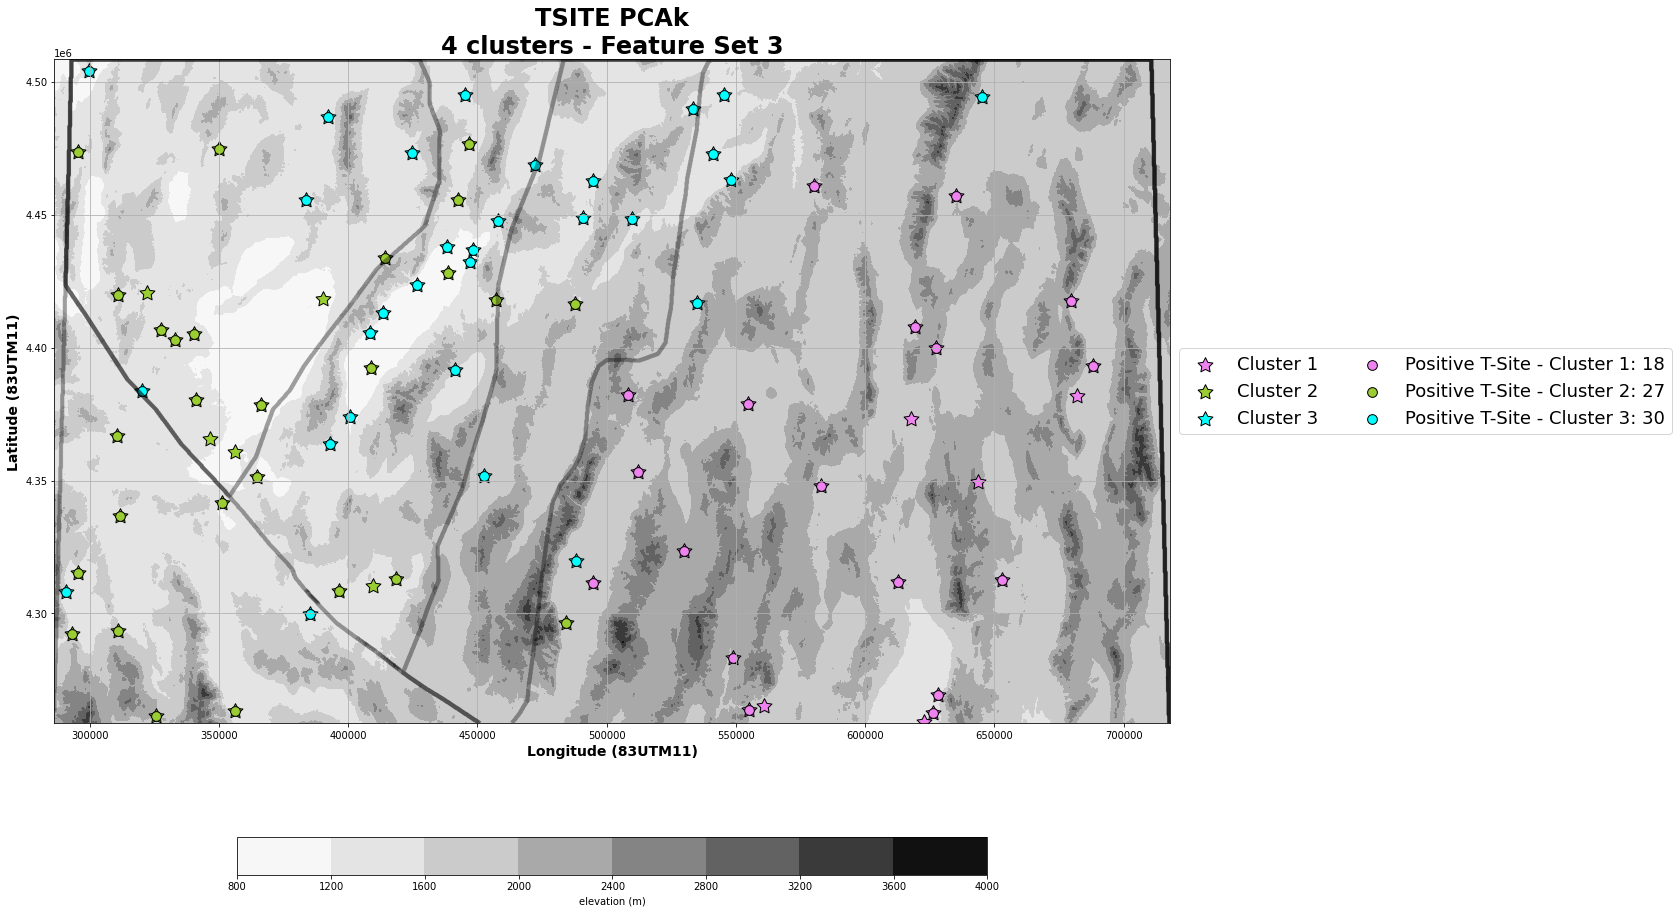

In [34]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = Info['X_83UTM11']
b = Info['Y_83UTM11']
Domains = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal',fraction=0.046, pad=0.14)
#plt.colorbar(im,fraction=0.046, pad=0.04)

#Plot positive sites
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'],c=c1  ,edgecolors='k', marker=(5, 1),s=245, label=label1)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'], c=c2, edgecolors='k',marker=(5, 1),s=245,label=label2)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'],   c=c3, edgecolors='k',marker=(5, 1),s=245, label=label3)
#plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, edgecolors='k',marker=(5, 1),s=245,label=label4)

#Plot negative sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'], c=c1, marker='o',edgecolors='k',s=95,label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c=c2, marker='o',edgecolors='k',s=95,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],   c=c3, marker='o',edgecolors='k',s=95,label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],   c=c4, marker='o',edgecolors='k',s=95,label=label8)

ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

plt.title('TSITE PCAk\n' + str(nCluster) + ' clusters - Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout